# Skeleton Matching using Skeleton Context

## Introduction
This is a demo of our skeleton matching using Skeleton Context described in publications below. If you use this code or part of it for your research please respectfully cite these publications:

[1] Kamani, M.M., Farhat, F., Wistar, S. and Wang, J.Z., 2017. Skeleton Matching with Applications in Severe Weather Detection, Applied Soft Computing. [Link1](http://www.sciencedirect.com/science/article/pii/S1568494617303009) [Link2](https://pdfs.semanticscholar.org/a90c/ffa078ed566a1cb046ec68fd7195f01c7a76.pdf)

[2] Kamani, M.M., Farhat, F., Wistar, S. and Wang, J.Z., 2016, December. Shape matching using skeleton context for automated bow echo detection. In Big Data (Big Data), 2016 IEEE International Conference on (pp. 901-908). IEEE. [Link1](http://ieeexplore.ieee.org/abstract/document/7840685/) [Link2](https://pdfs.semanticscholar.org/ae62/d5802980859ead8288f6ff436754253882d6.pdf)

som part of the codes are transfered from Matlab version of shape context developed by UC Berkeley's vision group [here](https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/code/sc_demo/)

In [1]:
from __future__ import division
import os
import skeletonContext as sc
from skeleton2Graph import skeleton2Graph, mat2gray
from skimage import io
from matplotlib import pyplot as plt
import numpy as np
from IPython import display

First we load images of the skeletons to be matched. Then we would start from one end and traverse to the other end of the skeleton in order to calulate thet tangent estimate of it.

In [2]:
s1 = mat2gray(io.imread(os.path.join(os.getcwd(), 'img/s1.png'),as_grey=True)).astype('float64')
s2 = mat2gray(io.imread(os.path.join(os.getcwd(), 'img/s2.png'),as_grey=True)).astype('float64')
_, edgeList1, _, _, _, _, _, _ = skeleton2Graph(s1,s1)
_, edgeList2, _, _, _, _, _, _ = skeleton2Graph(s2,s2)
s1Tangent, s1PointsList = sc.skeletonTangentEstimate(edgeList1)
s2Tangent, s2PointsList = sc.skeletonTangentEstimate(edgeList2)

Setting initial parameters for matching.

In [3]:
'''Initial Paramters'''
displayFlag=1
affineStartFlag=1
polarityFlag=0
nsamp= 100
costDum=0.15
numDumRate=0.6
thetaWeight=0.2
nbins_theta=12
nbins_r=5
r_inner=1/8
r_outer=2
tan_eps=1.0
numIter=20
betaInit=1
r=1
w=4
sf=2.5
neighborWeight = 0.6
skeletonMatchCost  = np.zeros(numIter)
affineCost         = np.zeros(numIter)
bendingEnergy      = np.zeros(numIter)
matchRatio         = np.zeros(numIter)
dimSize = np.max(np.array([s1.shape,s2.shape]),0)

In [4]:
t2 = sc.bdry_extract(s2,s2PointsList)
if len(s2PointsList) >= nsamp:
    s2PointsList, t2,s2Tangent = sc.get_samples(s2PointsList,t2,s2Tangent, nsamp)
else:
    raise ValueError('Skeleton 2 does not have enough samples')
t1 = sc.bdry_extract(s1,s1PointsList)
if len(s1PointsList) >= nsamp:
    s1PointsList, t1,s1Tangent = sc.get_samples(s1PointsList,t1,s1Tangent, nsamp)
else:
    raise ValueError('Skeleton 1 does not have enough samples')

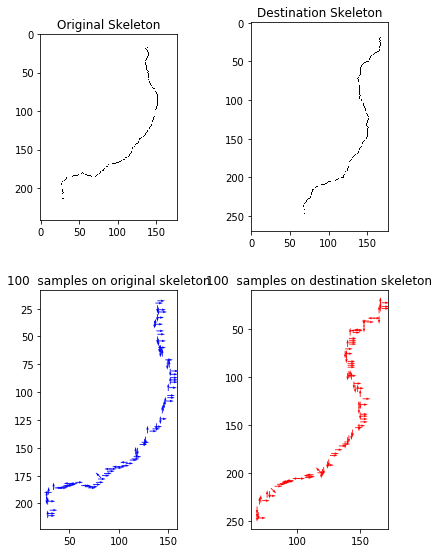

In [5]:
if displayFlag:
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(6,8))
    ax1.imshow(s1,cmap='gray_r')
    ax1.set_title('Original Skeleton')
    ax2.imshow(s2,cmap='gray_r')
    ax2.set_title('Destination Skeleton')
    ax3.quiver(s1PointsList[:,1],s1PointsList[:,0],np.sin(t1),np.cos(t1),color='b')
    ax3.invert_yaxis()
    ax3.set_title(str(len(s1PointsList)) + '  samples on original skeleton')
    ax4.quiver(s2PointsList[:,1],s2PointsList[:,0],np.sin(t2),np.cos(t2),color='r')
    ax4.invert_yaxis()
    ax4.set_title(str(len(s2PointsList)) +'  samples on destination skeleton')
    plt.tight_layout()
    plt.show()   

## Skeleton Context

Shape Context as a powerful shape descriptor represents a rough distribution of all other points with respect to a selected point in terms of distance and angle. It has quite number of applications in object recognition, pose recognition, animation construction, to name but a few. Shape context is used to find correspondences between samples from border of two shapes, and then find the cost of matching two shapes using bipartite graph matching. After that, parameters for an affine transform are extracted using thin plate spline ($TPS$), in order to map points from one shape to their correspondences in the other shape with warping the coordinates. Finally, a notion of shape distance for recognition purposes is exploited.

As there are a lot of fluctuations over the boundaries of some shapes in images, these make object matching with boundary samples less effective, and it may result in false matching. On the other hand, matching objects using skeleton samples sounds more robust in the sense that pruned skeleton contains complete shape topology regardless of its boundary variations. Hence, we use shape context to introduce a new descriptor called skeleton context. As it is shown in an example in the figure below, skeleton context is log-polar histogram, formed for each sample point on the skeleton. For each sample point $P_i$, the center of this log-polar histogram is located on that sample point, then each bin in the histogram represents the number of sample points in the specific angle and range of distance from the center (i.e. $P_i$) determined by that bin. We use the notation of $H_{SC}(P_i,r_{k_1},\theta_{k_2})$, to show the value of skeleton context's histogram for point $P_i$, in the $(r_{k_1},\theta_{k_2})$ bin. For instance, when $H_{SC}(P_i,r_{m},\theta_{n}) = 10$, it means that  in the distance range of $r_{m-1} \leq r < r_m$ and in the angle range of $\theta_{n-1} \leq \theta < \theta_n$ from the point $P_i$ in the skeleton, there are 10 other sample points. Basically, these histograms for each point visualize the distribution of other points on the skeleton with respect to that point, and hence it could play the object descriptor role for the shape matching purposes. As a result, we could use these descriptors as the feature data for bow echo detection in the next step. The skeleton context can be calculated using the following equation:
\begin{equation}
\begin{split}
H_{SC}(P_i,r_{k_1},\theta_{k_2}) =& |Bin(P_i,r_{k_1},\theta_{k_2})|\;,\\
Bin(P_i,r_{k_1},\theta_{k_2}) =& \big\{ \,X \in \mathbb{S} \mid\, r_{k_1-1} \leq \|X - P_i\|_2 < r_{k_1}\, 
\, \bigcap \, \theta_{k_2-1} \leq \measuredangle(X,P_i) < \theta_{k_2} \big\}\;,
\end{split}
\end{equation}
where $|.|$ shows the number of members in a set, $P_i$ is a sample point on the skeleton that we want to calculate its skeleton context, $\mathbb{S}$ is the set of sample points in the skeleton, and $\measuredangle(X,P_i)$ calculate the angle of a vector from $P_i$ to $X$ when $P_i$ is on the origin of coordinates, with respect to the horizontal coordinate. In figure below the skeleton context is computed for two points of two objects, which matched together in our algorithm. 

<img src="img/SC1.png" style="float: left; width: 20%; margin-right: 4%;margin-left: 28%; margin-bottom: 0.5em;">
<img src="img/SC2.png" style="float: left; width: 20%; margin-right: 28%; margin-bottom: 0.5em;">

## Skeleton Matching using Skeleton Context
We use four indicators to measure the quality of the matched skeletons. We can compute the cost of mapping each skeleton point $P_{i}^1$ in image $1$, to each skeleton point $P_{j}^2$ in image 2, which simply is the normalized difference between skeleton contexts of each pair of points in two images:
\begin{equation}
C(P_{i}^1,P_{j}^2) = 
\frac{1}{2}\sum_{k_1,k_2}\frac{\left(H_{SC}(P_{i}^1,r_{k_1},\theta_{k_2}) - H_{SC}(P_{j}^2,r_{k_1},\theta_{k_2})\right)^2}{H_{SC}(P_{i}^1,r_{k_1},\theta_{k_2}) + H_{SC}(P_{j}^2,r_{k_1},\theta_{k_2})}\;. 
\end{equation}
Having the cost of all possible mappings, we can use one of the algorithms designed to solve the bipartite graph matching, such as Hungarian method, which finds the minimum cost solution for matching points in image $1$ to image $2$. We define a threshold for the cost of matching, which indicates that if the minimum cost of matching one point from image $1$ to the points of image $2$ is greater than that threshold, then we announce that there is no matching point for this sample point in image $1$. This would end in having some points without a proper pair from other image, and hence the matching ratio would be less than $1$.
This is necessary for having partial shape matching. Next, we use an affine transformation to warp coordinates of one image, in order to map its skeleton to other image skeleton.
As mentioned, for this step we could use $TPS$ interpolation which tries to minimize the bending energy. In warping coordinates, we need an indicator that shows the intensity of changes on shapes in the transformation . For instance, if the transformation is just a simple rotation or relocation, this indicator should be low, which means the transformation has not warped coordinates extensively. But it would be high, if the transformation is warping coordinates significantly to map the points together. If the affine transformation could be written in mathematical form as:
\begin{equation}
\vec{y} = f(\vec{x}) = A\vec{x} + \vec{b}\;,
\end{equation}
with matrix $A$ as linear map and vector $\vec{b}$ as the offset for translation, then we can write our indicator for affine transformation as follows:
\begin{equation}
\mathcal{C}_{A} = \log\frac{\sigma_1(A)}{\sigma_2(A)}\;,
\end{equation}
where $\sigma_i(A)$ shows $i$-th singular value of matrix $A$, with $\sigma_1 \geq \sigma_2$. The more $\mathcal{C}_A$ is closer to zero, the more the skeleton of two shapes are similar, and the less coordinates are warped. Overall, we can use four different indicators for defining the distance between two skeletons:


* __Matching Cost__ ($\mathcal{C}_{MC}$) : This is defined based on the cost of matching points in two shapes, as it was computed in an equation above.
* __Bending Energy__ ($\mathcal{C}_{BE}$) : The energy that $TPS$ wants to minimize.
* __Affine Indicator__ ($\mathcal{C}_{A}$) : An indication of how transformation changes the coordinates. Defined in an equation ebove.
* __Matching Ratio__ ($\mathcal{C}_{MR}$) : It represents the ratio of the number of sample points in image $1$, that we could match with points in image $2$; to the total number of sample points. As it was discussed, some points would not match to any points if the cost of matching to the points in the other shape is greater than a predefined cost. This would allow the algorithm to achieve partial matching.


### Neighboring Effect
As it was mentioned, we need partial shape matching, as skeletons might be matched partially. Therefore, we should add an alteration to the shape matching part, in order to include partial shape matching in our algorithm. To do so, after the first iteration of shape matching, we can learn the initial mapping between sample points of two images. Because in our algorithm for extracting the edge list, points are listed in accordance with their spatial order, we can use this ordinal positions of sample points to define neighbors. For instance, if $(m-1)$-th and $(m+1)$-th sample points in image $1$ are mapped respectively to $(n-1)$-th and $(n+1)$-th sample points in image $2$ , then we expect $m$-th sample point in image $1$ to be mapped as close as possible to $n$-th sample point in image $2$. This is what we call neighboring effect, and we want to impose this constraint in the shape matching algorithm by adding a Neighbor Cost to the cost introduced before for shape matching. This Neighbor Cost for the point $m$ in the image 1 could be in the form of:
\begin{equation}
\mathcal{C}_N(n,m) =  \epsilon_N \left[1 - \exp \left(- \frac{((n - m) - E\{\delta_N\})^2}{2\sigma^2} \right) \right], 
\end{equation}
where $\epsilon_N$ is the maximum amplitude of this cost, and random variable $\delta_N$ is the difference between sample points' numbers in image $1$ with respect to the their mapped sample points' in image $2$. This cost would be a function of indexes of sample points in image 2 (\textit{i.e.} $n$) and image 1 (\textit{i.e.} $m$), hence for each pair of $(m,n)$ we would calculate a neighboring cost according to this function to be added to their mapping cost. For instance, if the average of the mapping differences($E\{\delta_N\}$) is 5, we expect to map the point 10 in image 2, to the point 5 in image 1. Based on this equation, it would add $0$ to the cost of mapping pair of $(10,5)$, however it increases as $m$ deviating from $5$. This Gaussian shape function would try to keep mapping of each sample point in accordance to its neighbors.

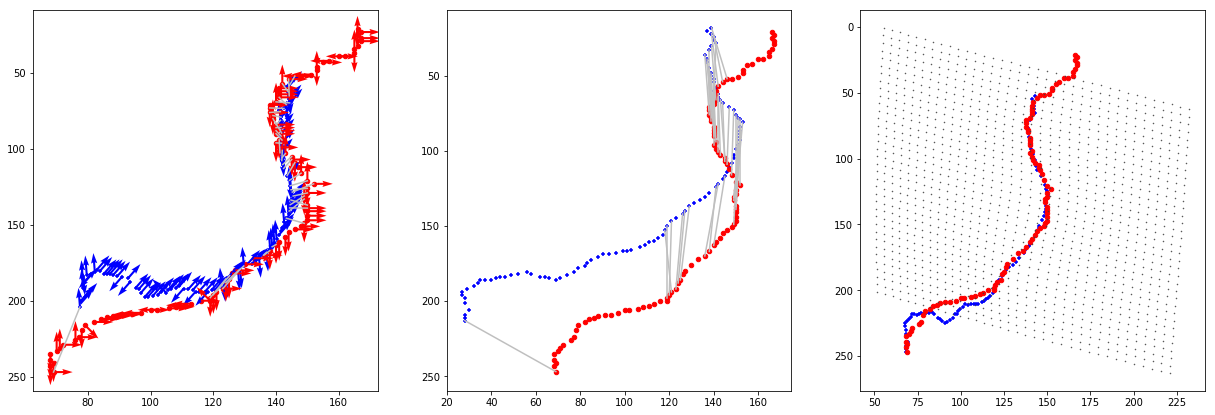

          Iteration       Bending Energy         Affine Cost       Matching Cost      Matching Ratio
                   1   2.43205225399e-06      0.973047106431      0.179564400068                0.41
                   2    0.00796486614269      0.622801978961      0.261173881383                0.41


In [6]:
'''Compute Matching points'''
X = np.copy(s1PointsList)
Y = np.copy(s2PointsList)
Xk = X
tk = t1

numDumPoints = int(numDumRate * nsamp)
outVec1 = np.zeros(nsamp)
outVec2 = np.zeros(nsamp)
neighborMap = np.tile(np.arange(1,nsamp+1),(nsamp,1))
neighborCost = np.zeros((nsamp,nsamp))
if displayFlag:
    f, (ax1, ax2,ax3) = plt.subplots(1,3,figsize=(21,7))
    ax1.invert_yaxis()
    ax2.invert_yaxis()
    ax3.invert_yaxis()
    x = np.linspace(0, dimSize[1], 36)
    y = np.linspace(0, dimSize[0],36)
    xv, yv = np.meshgrid(x, y)
    xv = np.reshape(xv.T,-1)
    yv = np.reshape(yv.T,-1)
    M = len(xv)
    printList = ['Bending Energy','Affine Cost', 'Matching Cost', 'Matching Ratio']
    row_format ="{:>20}" * (len(printList) + 1)
    print row_format.format("Iteration ", *printList)
for k in range(numIter):
    pointHistogram1, meanDistance1 = sc.skeletonContext(Xk.T,np.zeros(nsamp),nbins_theta,nbins_r,r_inner,r_outer,outVec1)
    pointHistogram2, meanDistance2 = sc.skeletonContext(Y.T,np.zeros(nsamp),nbins_theta,nbins_r,r_inner,r_outer,outVec2)
    
    if affineStartFlag:
        if k == 0:
            lambda_o = 1000;
        else:
            lambda_o = betaInit * pow(r,k-1)
    else:
        lambda_o = betaInit * pow(r,k)
    beta_k=(pow(meanDistance2,2)) * lambda_o
    
    costMatShape = sc.HistCost(pointHistogram1,pointHistogram2)
    thetaDiff = np.tile(tk,[nsamp,1]).T - np.tile(t2,[nsamp,1])
    
    if polarityFlag:
        costMatTheta = 0.5 * (1 - np.cos(thetaDiff))
    else:
        costMatTheta = 0.5 * (1 - np.cos(2 * thetaDiff))
    
    costMat = (1 - thetaWeight) * costMatShape + thetaWeight * costMatTheta
    costMat += neighborCost
    
    # Calculate Skeleton Context cost
    costMatTemp = costMat - neighborCost
    a1 = np.min(costMatTemp,0)
    a2 = np.min(costMatTemp,1)
    skeletonMatchCost[k] = max(np.mean(a1),np.mean(a2))
    
    numMatchPoints = nsamp + numDumPoints
    costMatDum = costDum * np.ones((numMatchPoints,numMatchPoints))
    costMatDum[0:nsamp,0:nsamp] = costMat
    matchedVec, _ = sc.hungarian(costMatDum)
    matchedVec2 = np.argsort(matchedVec)
    
    '''Neighboring Effect'''
    s1PointsMatchedInd = matchedVec2[:nsamp] <= nsamp
    s1PointsMatched = np.argwhere(s1PointsMatchedInd)
    matchDifference = s1PointsMatched - matchedVec2[s1PointsMatched]
    matchDifferenceMean = np.mean(matchDifference)
    matchDifferenceStd = np.std(matchDifference)
    outlierInd = (matchDifference >=  (matchDifferenceMean + 2.5 * matchDifferenceStd)) | (matchDifference <=  (matchDifferenceMean - 2.5 * matchDifferenceStd))
    matchRatio[k] = len(s1PointsMatched) / nsamp
    if matchRatio[k] <= 0.65:
        if (k != 0 & outlierInd.any() ):
            outlierMatchS2Points = s1PointsMatched[outlierInd]
            outlierMatchS1Points = matchedVec2[outlierMatchS2Points]
            matchedVec2[outlierMatchS2Points] = numMatchPoints
            matchedVec[outlierMatchS1Points] = numMatchPoints
            
            s1PointsMatchedInd = matchedVec2[:nsamp] <= nsamp
            s1PointsMatched = np.argwhere(s1PointsMatchedInd)
            matchDifference = s1PointsMatched - matchedVec2[s1PointsMatched]
            matchDifferenceMean = np.mean(matchDifference)
            matchDifferenceStd = np.std(matchDifference)
        
        neighborMean = neighborMap.T - matchDifferenceMean
        neighborCost = neighborWeight * (1 - np.exp(- (neighborMap - neighborMean)**2 / (2 * 10**2)))
    else:
        neighborCost = np.zeros((nsamp,nsamp))
    
    outVec1 = matchedVec2[:nsamp] > nsamp
    outVec2 = matchedVec[:nsamp] > nsamp
    
    X2 = np.nan * np.ones((numMatchPoints,2))
    X2[:nsamp,:] = np.copy(Xk)
    X2 = X2[matchedVec - 1,:]
    X2b = np.nan * np.ones((numMatchPoints,2))
    X2b[:nsamp,:] = X
    X2b = X2b[matchedVec - 1,:]
    Y2 = np.nan * np.ones((numMatchPoints,2))
    Y2[:nsamp,:] = np.copy(Y)
    
    indGood = np.where(~np.isnan(X2b[:nsamp,0]))[0]
    numGood = len(indGood)
    X3b = X2b[indGood,:]
    Y3  = Y2[indGood,:]
    
    if displayFlag:
        ax1.clear()
        ax1.scatter(X2[:,1],X2[:,0],c='b', marker='+',s=20)
        ax1.scatter(Y2[:,1],Y2[:,0],c='r',marker='o',s=20)
        ax1.plot(np.stack((X2[:,1],Y2[:,1]),axis=1).T,np.stack((X2[:,0],Y2[:,0]),axis=1).T,c='0.75')
        ax1.quiver(Xk[:,1],Xk[:,0],np.sin(tk),np.cos(tk),color='b')
        ax1.quiver(Y[:,1],Y[:,0],np.sin(t2),np.cos(t2),color='r')
        ax1.invert_yaxis()
        display.clear_output(wait=True)
        display.display(plt.gcf())
        ax2.clear()
        ax2.scatter(X[:,1],X[:,0],c='b', marker='+',s=20)
        ax2.scatter(Y[:,1],Y[:,0],c='r',marker='o',s=20)
        ax2.plot(np.stack((X2b[:,1],Y2[:,1]),axis=1).T,np.stack((X2b[:,0],Y2[:,0]),axis=1).T,c='0.75')
        ax2.invert_yaxis()
        display.clear_output(wait=True)
        display.display(plt.gcf())
        
        
    
    # Calculate bending energy
    cx,cy,E,_ = sc.bookstien(X3b , Y3, beta_k)
    bendingEnergy[k] = E
    # Calculating affine cost
    A = np.vstack((cx[numGood + 1:numGood + 3], cy[numGood + 1:numGood + 3]))
    _,s,_ = np.linalg.svd(A)
    affineCost[k] = np.log(s[0]/s[1])
    
    # warp coordinates
    fx_aff = np.dot(cx[numGood:numGood + 3].T,np.vstack((np.ones((1,nsamp)),X.T)))
    d2 = sc.dist2(X3b, X)
    U = d2 * np.log(d2 + np.finfo(float).eps)
    fx_wrp = np.dot(cx[:numGood].T,U)
    fx = fx_aff + fx_wrp
    fy_aff = np.dot(cy[numGood:numGood + 3].T,np.vstack((np.ones((1,nsamp)),X.T)))
    fy_wrp = np.dot(cy[:numGood].T,U)
    fy = fy_aff + fy_wrp
    
    Z=np.vstack((fx,fy)).T
    
    Xtan = X + tan_eps * np.vstack((np.cos(t1),np.sin(t1))).T
    fx_aff = np.dot(cx[numGood:numGood + 3].T,np.vstack((np.ones((1,nsamp)),Xtan.T)))
    d2 = sc.dist2(X3b, Xtan)
    U = d2 * np.log(d2 + np.finfo(float).eps)
    fx_wrp = np.dot(cx[:numGood].T,U)
    fx = fx_aff + fx_wrp
    fy_aff = np.dot(cy[numGood:numGood + 3].T,np.vstack((np.ones((1,nsamp)),Xtan.T)))
    fy_wrp = np.dot(cy[:numGood].T,U)
    fy = fy_aff + fy_wrp
    
    Ztan = np.vstack((fx,fy)).T
    tk = np.arctan2(Ztan[:,1] - Z[:,1], Ztan[:,0] - Z[:,0])
    
    
    if displayFlag:
        ax3.clear()
        ax3.scatter(Z[:,1],Z[:,0],c='b', marker='+',s=20)
        ax3.scatter(Y[:,1],Y[:,0],c='r',marker='o',s=20)
        fx_aff = np.dot(cx[numGood:numGood + 3].T,np.vstack((np.ones((1,M)),np.stack((xv,yv)))))
        d2 = sc.dist2(X3b,np.stack((xv,yv)).T)
        fx_wrp = np.dot(cx[:numGood].T, d2 * np.log(d2 + np.finfo(float).eps))
        fx = fx_aff + fx_wrp
        fy_aff = np.dot(cy[numGood:numGood + 3].T,np.vstack((np.ones((1,M)),np.stack((xv,yv)))))
        fy_wrp = np.dot(cy[:numGood].T, d2 * np.log(d2 + np.finfo(float).eps))
        fy = fy_aff + fy_wrp
        ax3.scatter(fy,fx,c='0.25',marker='.', s=1)
        ax3.invert_yaxis()
        display.clear_output(wait=True)
        display.display(plt.gcf())
        
    # Update Paramters
    Xk = Z
    matchingData = np.vstack((bendingEnergy[0:k+1],affineCost[0:k+1],skeletonMatchCost[0:k+1],matchRatio[0:k+1])).T
    print row_format.format("Iteration ", *printList)
    for i, row in enumerate(matchingData):
        print row_format.format(i+1, *row)
    if np.sum(matchingData[-1,0:3]) < 0.9:
        break
plt.close()     
    
    